In [279]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import h5py
%matplotlib inline
from matplotlib import rc
import matplotlib.gridspec as gridspec
import pickle
from matplotlib import cm
import matplotlib 
import os
import os.path
from cycler import cycler
rc('font',**{'family':'sans-serif', 'sans-serif':['Helvetica']})
import pymongo
from copy import copy
import pandas as pd
from matplotlib.colors import hsv_to_rgb


In [41]:
DATA_DIR = os.environ.get('BRAINSTORM_DATA_DIR')
dataset_order = ['easy_superpos', 'bars', 'corners', 'shapes', 'mnist_shapes', 'multi_mnist_thresholded'] #, 'tetris']
cmap = sns.cubehelix_palette(12, start=1., rot=1.5, light=.8, dark=0.2, hue=1.0, as_cmap=True)
dataset_names = {
    'bars': 'Bars',
    'corners': 'Corners', 
    'easy_superpos': 'Simple Superposition',
    'mnist_shapes': 'MNIST+Shape',
    'multi_mnist_thresholded': 'Multi MNIST',
    'shapes': 'Shapes'
}


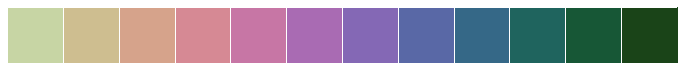

In [42]:
sns.palplot(sns.cubehelix_palette(12, start=1., rot=1.5, light=.8, dark=0.2, hue=1.0))

In [45]:
all_data = []
all_groups = []

for ds in dataset_order:
    with h5py.File(os.path.join(DATA_DIR, ds + '.h5'), 'r') as f:
        all_data.append(f['test/default'][0, examples[ds]])
        all_groups.append(f['test/groups'][0, examples[ds]])

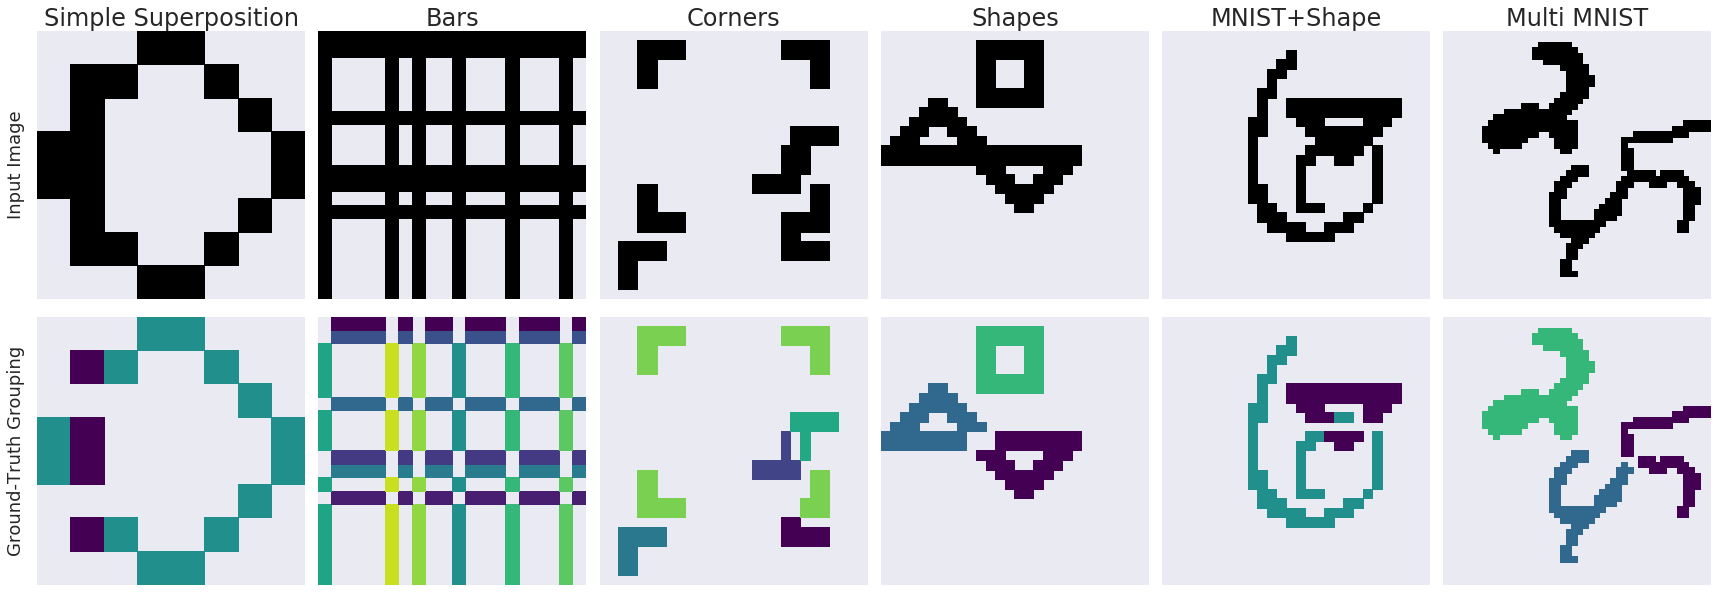

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=len(dataset_names), figsize=(5*len(dataset_names), 10))
for i, ds in enumerate(dataset_order):
    data = all_data[i][:, :, 0]
    groups = all_groups[i][:, :, 0]
    sns.heatmap(data, mask=data==0, square=True, xticklabels=False, yticklabels=False, cmap='Greys', cbar=False, ax=axes[0, i])#, linewidth=0.01)
    sns.heatmap(groups, mask=groups==0, square=True, xticklabels=False, yticklabels=False, cmap='viridis_r', cbar=False, ax=axes[1, i])#, linewidth=0.01)
    axes[0, i].set_title(dataset_names[ds], fontsize=24) #fontweight='bold')

axes[0, 0].set_ylabel('Input Image', fontsize=18)
axes[1, 0].set_ylabel('Ground-Truth Grouping', fontsize=18)
plt.subplots_adjust(hspace=0.05, wspace=0.05)

In [49]:
fig.savefig('figures/dataset_preview.pdf', bbox_inches='tight', pad_inches=0)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


# Object Predictability

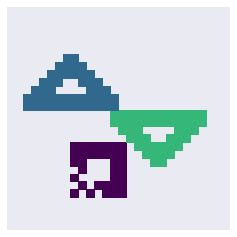

In [7]:
i = 23
with h5py.File(os.path.join(DATA_DIR, 'shapes.h5'), 'r') as f:
    x = f['test/groups'][0, i, :, :, 0]

def build_checkerboard(w, h) :
    re = np.r_[ w*[0,1] ]        # even-numbered rows
    ro = np.r_[ w*[1,0] ]        # odd-numbered rows
    return np.row_stack(h*(re, ro))
    
corrupted_x = x.copy()
corrupted_x[20:24, 8:12] *= build_checkerboard(2, 2)
sns.heatmap(corrupted_x, mask=corrupted_x==0, square=True, xticklabels=False, yticklabels=False, cmap='viridis_r', cbar=False)#, linewidth=0.01)
plt.savefig('figures/object_predictability.pdf', bbox_inches='tight', pad_inches=0)

# Awesome Plot
For this to work you must first run evaluate and produce the results files.

In [276]:
def color_spines(ax, lw=2, color='green'):
    for sn in ['top', 'bottom', 'left', 'right']:
        ax.spines[sn].set_linewidth(lw)
        ax.spines[sn].set_color(color)
        ax.spines[sn].set_visible(True)

def awesome_plot(problem, nr_iters, K, example_idxs, iterations, figsize, wspace, hspace, palette):
    example_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I')
    
    results_filename = '{}_{}_{}.pkl'.format(problem, nr_iters, K)
    with open(results_filename, 'rb') as f:
        scores, results, data, confidences, likelihoods = pickle.load(f)

    with h5py.File('/home/greff/Datasets/{}.h5'.format(problem)) as f:
        true_groups = f['test']['groups'][:]

    sort_idxs = np.argsort(scores)
    scores = scores[sort_idxs]
    results = results[:, sort_idxs, :]
    data = data[:, sort_idxs, :]
    confidences = confidences[sort_idxs]
    likelihoods = likelihoods[:, sort_idxs]
    tgroups = true_groups[0, sort_idxs]
    
    if results.shape[-1] != 3:
        nr_colors = results.shape[-1]
        hsv_colors = np.ones((nr_colors, 3))
        hsv_colors[:, 0] = (np.linspace(0, 1, nr_colors, endpoint=False) + 2/3) % 1.0
        color_conv = hsv_to_rgb(hsv_colors)
        results = results.reshape(-1, nr_colors).dot(color_conv).reshape(results.shape[:-1] + (3,))

    fig = plt.figure(figsize=figsize)

    nr_examples = len(example_idxs)
    nr_iterations = len(iterations)
    im_size = data.shape[2]

    # Set up the Grid
    gs = gridspec.GridSpec(nr_iterations + 5, nr_examples + 2, 
                           height_ratios=[1, 0.3, 1] + [1]*nr_iterations + [0.7, 0.3], 
                           width_ratios=[1]*nr_examples + [0.1, 1])
    gs.update(left=0.0, right=1.0, wspace=wspace, hspace=hspace)

    score_ax = fig.add_subplot(gs[0, :])
    data_axes = [fig.add_subplot(gs[2, i]) for i in range(nr_examples)]
    iter_axes = [[fig.add_subplot(gs[iter_nr, i]) for i in range(nr_examples)] for iter_nr in range(3, nr_iterations+3)]
    gt_axes = [fig.add_subplot(gs[nr_iterations + 3:, i]) for i in range(nr_examples)]
    likelihood_ax = fig.add_subplot(gs[3:nr_iterations + 3, nr_examples+1])
    final_ax = fig.add_subplot(gs[nr_iterations+3, nr_examples+1])




    # Score and confidences 
    score_ax.plot(scores, 'k', label='score')
    score_ax.plot(confidences, 'k', alpha=0.2, label='confidence')
    #score_ax.set_ylabel('Score')
    score_ax.set_xticks([])
    score_ax.set_title('Test Samples Sorted by Score')
    score_ax.legend(loc='lower right')

    # Data
    transFigure = fig.transFigure.inverted()
    fig.lines = []
    for col, i in enumerate(example_idxs):
        data_ax = data_axes[col]
        data_ax.set_title(example_names[col], weight='bold', color=palette[col], x=0.5)

        d = data[0, i, :, :, 0]
        sns.heatmap(d, mask=d==0, square=True, xticklabels=False, yticklabels=False, 
                    cmap=cm.Greys, linewidth=0, ax=data_ax, cbar=False)

        # mark the positions in the score plot
        score_ax.axvline(x=i, color=palette[col], linewidth=0.5)
        score_ax.plot([i], scores[i], 'ko')
        score_ax.plot([i], confidences[i], 'k.')

        # Connect the plots 
        coord1 = transFigure.transform(score_ax.transData.transform([i, score_ax.get_ylim()[0]]))
        coord2 = transFigure.transform(data_axes[col].transData.transform([im_size/2,im_size]))

        line = matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),
                                       transform=fig.transFigure, color=palette[col])
        fig.lines.append(line)
        color_spines(data_ax, color=palette[col], lw=3)

    data_axes[0].set_ylabel('Input Image', labelpad=-3)

    # Iterations
    for it_nr, row_axes in zip(iterations, iter_axes):
        for col, (ex_nr, ax) in enumerate(zip(example_idxs, row_axes)):
            ax.imshow(results[it_nr, ex_nr, :, :, 0, :], interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
            #color_spines(ax, color=palette[col])
        #row_axes[0].set_ylabel('{}'.format(it_nr))
        
    iter_axes[len(iter_axes)//2][0].set_ylabel('Cluster Assignments')


    # Ground-Truth
    for col, (ex_nr, ax) in enumerate(zip(example_idxs, gt_axes)):
        gt = tgroups[ex_nr, :, :, 0]
        sns.heatmap(gt, mask=gt==0, square=True, xticklabels=False, yticklabels=False,  
                    cbar=False, cmap='viridis_r', ax=ax)#, linewidth=0.01)
        #color_spines(ax, color=palette[col])
    gt_axes[0].set_ylabel('Ground-Truth', labelpad=-3)


    # likelihoods
    x = np.arange(0, 10.5, 1.)[::-1]
    y = likelihoods[::2, example_idxs]

    likelihood_ax.set_prop_cycle(cycler('color', palette))
    lines = likelihood_ax.plot(y, x)
    likelihood_ax.legend(lines, example_names, loc='lower left')
    likelihood_ax.yaxis.tick_right()
    likelihood_ax.set_yticks(range(11))
    likelihood_ax.set_yticklabels(['{}'.format(j) for j in range(0, 11)[::-1]])
    likelihood_ax.set_ylim([-0.1, 10.1])
    likelihood_ax.yaxis.set_label_position("right")
    likelihood_ax.set_ylabel('Iteration nr', rotation=-90, labelpad=10)

    likelihood_ax.xaxis.set_label_position("top")
    likelihood_ax.xaxis.tick_top()
    likelihood_ax.set_xlabel('log Likelihood')
    plt.setp( likelihood_ax.xaxis.get_majorticklabels(), rotation=-90)
    #likelihood_ax.set_xticks([-600, -400, -200, 0])

    # Connect the iterations 
    for i, iter_nr in enumerate(iterations):
        coord1 = transFigure.transform(iter_axes[i][-1].transData.transform([im_size, im_size/2]))
        coord2 = transFigure.transform(likelihood_ax.transData.transform(
                [likelihood_ax.get_xlim()[0], nr_iterations - iter_nr + 3]))

        line = matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),
                                   transform=fig.transFigure, color='k', lw=1, alpha=0.3)
        likelihood_ax.axhline(nr_iterations - iter_nr + 3, color='k', lw=1, alpha=0.3)
        fig.lines.append(line)

    # Fat dots on top of likelihood plot
    likelihood_ax.set_prop_cycle(cycler('color', palette))
    likelihood_ax.plot(y[iterations], x[iterations], 'o')

    # zoomed in likelihood
    for col, final_y in enumerate(y[-1]):
        final_ax.plot(final_y, [0], '.', color=palette[col])

    final_ax.set_yticks([])
    final_ax.set_yticklabels([])
    final_ax.set_ylim(-0.01, 1)

    for col, final_y in enumerate(y[-1]):      
        coord1 = transFigure.transform(likelihood_ax.transData.transform([final_y, 0]))
        coord2 = transFigure.transform(final_ax.transData.transform([final_y, 0]))
        line = matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),
                                   transform=fig.transFigure, color=palette[col])
        fig.lines.append(line)
    final_ax.yaxis.set_label_position("right")
    final_ax.set_ylabel('Zoomed', rotation=-90, labelpad=10)
    plt.setp(final_ax.xaxis.get_majorticklabels(), rotation=-90)
    return fig

N = len(scores)
first = int(0.02 * N)
last = int(0.98 * N)
start1, stop1 = int(N / 5), int(N / 5 * 2) 
start2, stop2 = int(N / 5 * 3), int(N / 5 *4)
example_idxs = [0, #np.argmax(confidences[:first]), 
                np.argmin(confidences[start1:stop1]) + start1, 
                np.argmax(confidences[start2:stop2]) + start2, 
                N-1] # np.argmax(confidences[last:]) + last]

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


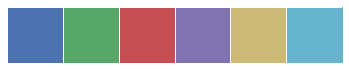

In [277]:
#problem = 'shapes'
#example_idxs = [0, 20, 60, 82, 103, 119] # easy_superpos
#example_idxs = [1, 300, 500, 700, 900, 999] # bars, corners, shapes
#example_idxs = [1, 300, 500, 700, 900, 998] # multi_mnist_thresholded

#iterations = np.array([0, 1, 2, 3, 5, 7, 10])
palette = sns.color_palette()
#palette = sns.color_palette("hls", 7)
#figsize = (8, 15)
#wspace, hspace = 0.08, 0.02


#
sns.palplot(palette)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


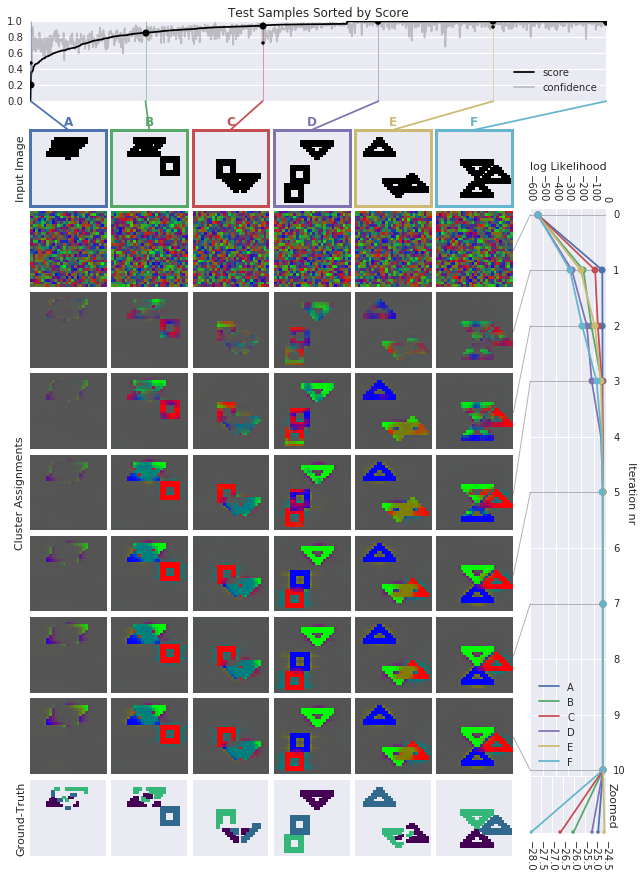

In [285]:
fig = awesome_plot('shapes', 10, 3, 
                   example_idxs=[1, 200, 403, 604, 803, 999],
                   iterations=np.array([0, 1, 2, 3, 5, 7, 10]),
                   figsize=(8, 15),
                   wspace=0.08,
                   hspace=0.02,
                   palette=palette)
fig.savefig('figures/shapes_iter_examples.pdf', bbox_inches='tight', pad_inches=0)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


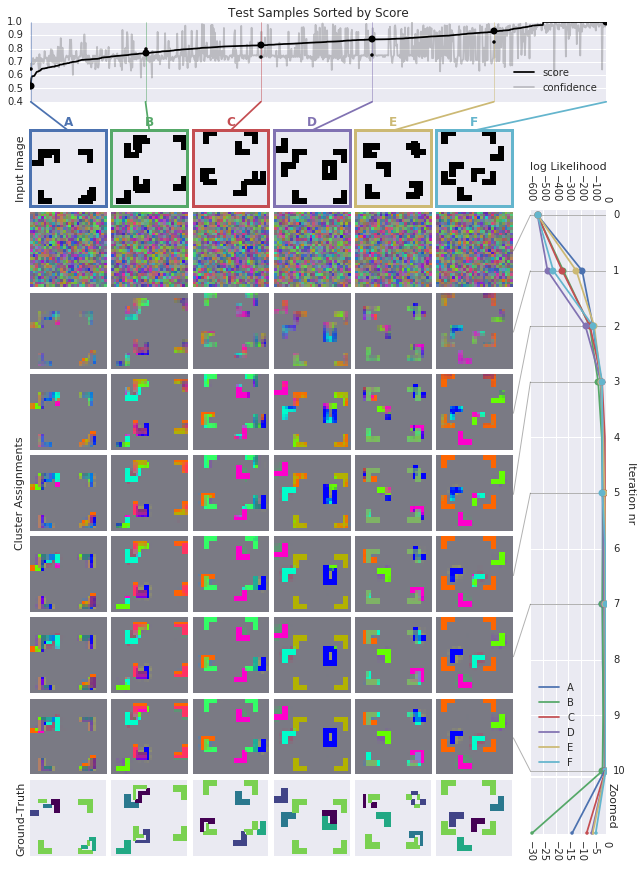

In [290]:
fig = awesome_plot('corners', 10, 5, 
                   example_idxs=[1, 200, 400, 593, 804, 999],
                   iterations=np.array([0, 1, 2, 3, 5, 7, 10]),
                   figsize=(8, 15),
                   wspace=0.08,
                   hspace=0.02,
                   palette=palette)
fig.savefig('figures/corners_iter_examples.pdf', bbox_inches='tight', pad_inches=0)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


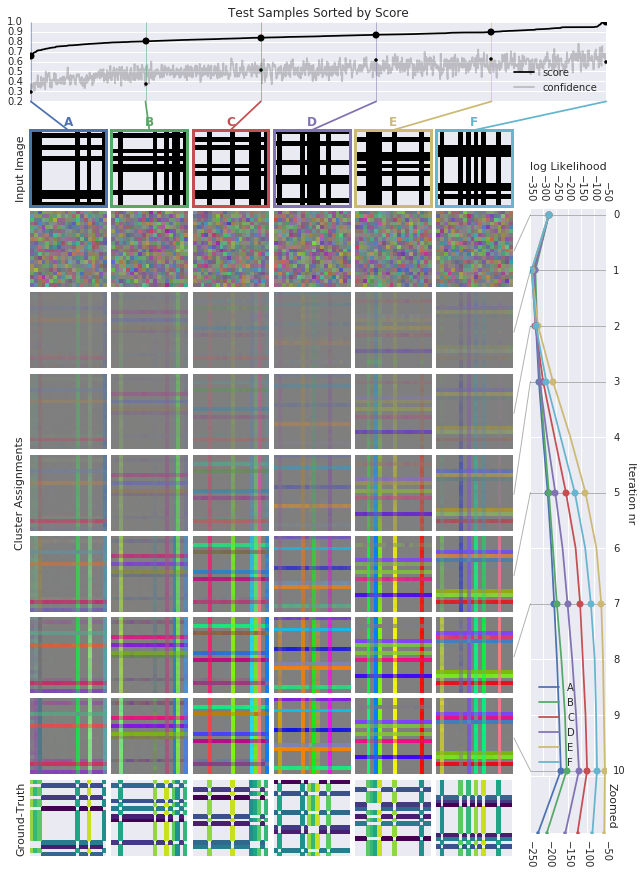

In [28]:
fig = awesome_plot('bars', 10, 12, 
                   example_idxs=[1, 200, 400, 600, 800, 999],
                   iterations=np.array([0, 1, 2, 3, 5, 7, 10]),
                   figsize=(8, 15),
                   wspace=0.08,
                   hspace=0.02,
                   palette=palette)
fig.savefig('figures/bars_iter_examples.pdf', bbox_inches='tight', pad_inches=0)

ERROR! Session/line number was not unique in database. History logging moved to new session 485


/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


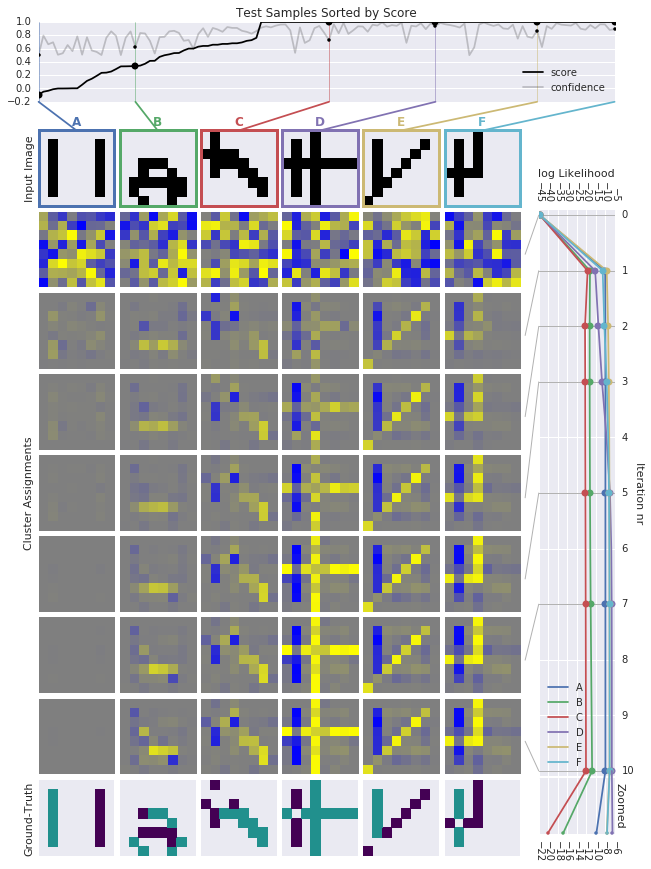

In [22]:
fig = awesome_plot('easy_superpos', 10, 2, 
                   example_idxs=[0, 20, 60, 82, 103, 119],
                   iterations=np.array([0, 1, 2, 3, 5, 7, 10]),
                   figsize=(8, 15),
                   wspace=0.08,
                   hspace=0.02,
                   palette=palette)
fig.savefig('figures/easy_superpos_iter_examples.pdf', bbox_inches='tight', pad_inches=0)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


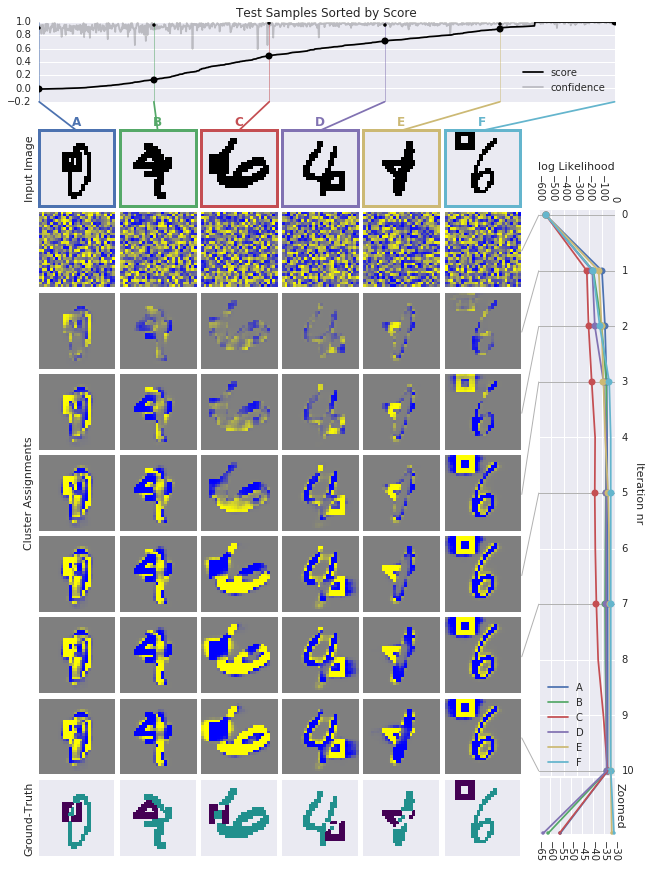

In [24]:
fig = awesome_plot('mnist_shapes', 10, 2, 
                   example_idxs=[1, 200, 400, 600, 800, 999],
                   iterations=np.array([0, 1, 2, 3, 5, 7, 10]),
                   figsize=(8, 15),
                   wspace=0.08,
                   hspace=0.02,
                   palette=palette)
fig.savefig('figures/mnist_shapes_iter_examples.pdf', bbox_inches='tight', pad_inches=0)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


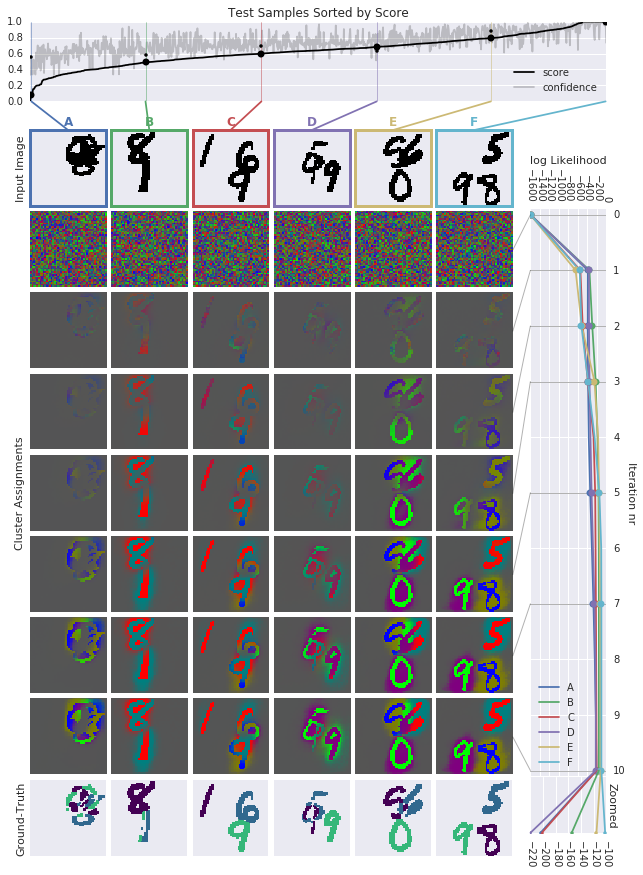

In [27]:
fig = awesome_plot('multi_mnist_thresholded', 10, 3, 
                   example_idxs=[2, 200, 401, 601, 799, 998],
                   iterations=np.array([0, 1, 2, 3, 5, 7, 10]),
                   figsize=(8, 15),
                   wspace=0.08,
                   hspace=0.02,
                   palette=palette)
fig.savefig('figures/multi_mnist_thresholded_iter_examples.pdf', bbox_inches='tight', pad_inches=0)

# Loss vs Score

In [233]:
client = pymongo.MongoClient()
c = client.binding4.default.runs
datasets = {
    'Bars': {'config.dataset.name':'bars', 'status': 'COMPLETED'},
    'Corners': {'config.dataset.name':'corners', 'status': 'COMPLETED'},
    'Shapes': {'config.dataset.name': 'shapes', 'status': 'COMPLETED'},
    'MNIST+Shape': {'config.dataset.name': 'mnist_shapes', 'status':'COMPLETED'},
    'Multi MNIST': {'config.dataset.name': 'multi_mnist_thresholded', 'status':'COMPLETED'},
    'Simple Superposition': {'config.dataset.name': 'easy_superpos', 'status': 'COMPLETED'}
}

In [234]:
score_loss = pd.DataFrame()

for name, query in datasets.items():
    query = copy(query)
    query['result'] = {'$gt': 0.1}
    print(name, c.find(query).count())
    xy = np.array([(r['result'], r['info']['best_val_loss']) for r in c.find(query)])
    score_loss = score_loss.append(pd.DataFrame({'Score': xy[:, 0], 'Loss': xy[:, 1], 'Dataset':[name] * xy.shape[0]}))

Shapes 91
Multi MNIST 34
Simple Superposition 75
Bars 48
Corners 88
MNIST+Shape 100


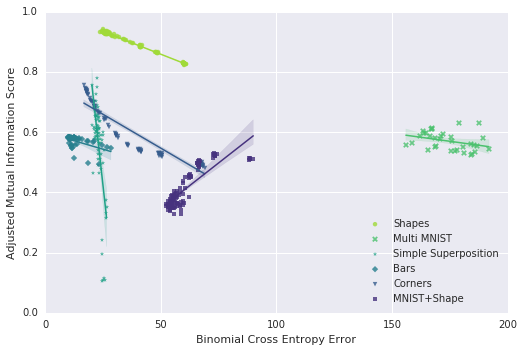

In [266]:
facet = sns.lmplot(y='Score', x='Loss', hue='Dataset', data=score_loss, palette='viridis_r', 
                   legend_out=False, truncate=True, line_kws={'lw':1.5}, #logx=True,
                   markers=['o', 'x', '*', 'D', 'v', 's'])
facet.fig.set_figwidth(8)
facet.fig.set_figheight(5)
facet.ax.legend(loc='lower right')

#facet.ax.set_xscale('log')
facet.ax.set_xlim((0, 200))
facet.ax.set_xlabel('Binomial Cross Entropy Error')
facet.ax.set_ylabel('Adjusted Mutual Information Score')

In [267]:
facet.fig.savefig('figures/score_vs_loss.pdf', bbox_inches='tight', pad_inches=0)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


# Overall Results

In [268]:
datasets = ['mnist_shapes', 'easy_superpos', 'multi_mnist_thresholded', 'shapes', 'corners', 'bars'][::-1]
dataset_names = {
    'bars': 'Bars',
    'corners': 'Corners', 
    'easy_superpos': 'Simple Superposition',
    'mnist_shapes': 'MNIST+Shape',
    'multi_mnist_thresholded': 'Multi MNIST',
    'shapes': 'Shapes'
}
Ks = [2, 3, 5, 12]
iters = 20

In [269]:
all_scores = pd.DataFrame()
for ds in datasets:
    for k in Ks:
        results_filename = "scores/{}_{}_{}_long.pkl".format(ds, iters, k)
        if not os.path.exists(results_filename):
            continue
        with open(results_filename, 'rb') as f:
            mean_score = pickle.load(f)[:, -1, :, 0].mean(1)
            pd_score = pd.DataFrame({
                    'AMI Score': mean_score,
                    '# Clusters': ['{}'.format(k)] * len(mean_score),
                    'Dataset': [dataset_names[ds]] * len(mean_score)
                })
            all_scores = all_scores.append(pd_score, ignore_index=True)

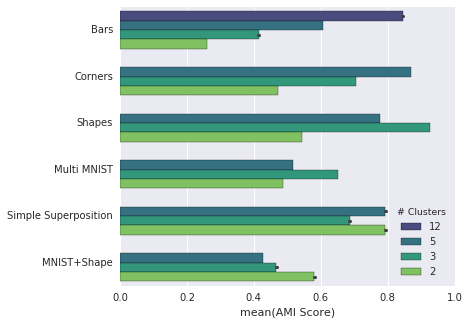

In [270]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(y='Dataset', x='AMI Score', hue="# Clusters", palette='viridis', 
            order=[dataset_names[ds] for ds in datasets], hue_order=['{}'.format(k) for k in Ks][::-1],
            data=all_scores, ax=ax) # errcolor=(0, 0, 0, 0)
ax.set_ylabel('')

In [271]:
fig.savefig('figures/results.pdf', bbox_inches='tight', pad_inches=0)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


# Convergence

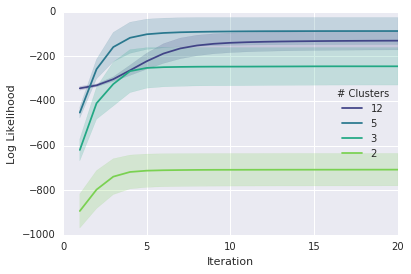

In [243]:
ds = 'bars'
Ks = [12, 5, 3, 2]
iters = 20
palette = sns.color_palette("viridis", len(Ks))

fig, ax = plt.subplots(figsize=(6, 4))
iter_llhs = pd.DataFrame()
for i, k in enumerate(Ks):
    results_filename = "scores/{}_{}_{}_long.pkl".format(ds, iters, k)
    if not os.path.exists(results_filename):
        continue
    with open(results_filename, 'rb') as f:
        llhs = pickle.load(f)[:1, 1:, :, 3]
        m = llhs.mean((0, 2))
        s = llhs.std((0, 2))
        ax.plot(np.arange(1, len(m)+1), m, color=palette[i], label='{}'.format(k))
        ax.fill_between(np.arange(1, len(m)+1), m+s, m-s, alpha=0.2, color=palette[i])
ax.legend(loc='center right', title='# Clusters')
ax.set_xlabel('Iteration')
ax.set_ylabel('Log Likelihood')

In [217]:
fig.savefig('figures/bars_convergence.pdf', bbox_inches='tight', pad_inches=0)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


# Multi vs Single Training

In [272]:
iters = 20
datasets = ['shapes', 'corners', 'bars', 'multi_mnist_thresholded', 'mnist_shapes']
dataset_names = {
    'bars': 'Bars',
    'corners': 'Corners', 
    'easy_superpos': 'Simple Superposition',
    'mnist_shapes': 'MNIST+\nShape',
    'multi_mnist_thresholded': 'Multi\nMNIST',
    'shapes': 'Shapes'
}
dataset_Ks = {
    'bars': 12,
    'corners': 5, 
    'mnist_shapes': 2,
    'multi_mnist_thresholded': 3,
    'shapes': 3
}
filenames = {
    'multi': "scores/{}_{}_{}_multi_m.pkl",
    'single': "scores/{}_{}_{}_long.pkl"
}


all_scores = pd.DataFrame()
for ds in datasets:
    for traint in ['multi', 'single']:
        results_filename = filenames[traint].format(ds, iters, dataset_Ks[ds])
        if not os.path.exists(results_filename):
            print(':(', ds)
            continue
        with open(results_filename, 'rb') as f:
            mean_score = pickle.load(f)[:, -1, :, 0].mean(1)
            pd_score = pd.DataFrame({
                    'AMI Score': mean_score,
                    'Training': [traint] * len(mean_score),
                    'Dataset': [dataset_names[ds]] * len(mean_score)
                })
            all_scores = all_scores.append(pd_score, ignore_index=True)

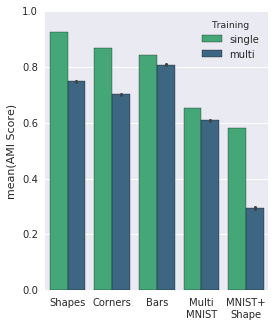

In [273]:
fig, ax = plt.subplots(figsize=(4, 5))
sns.barplot(x='Dataset', y='AMI Score', hue="Training", palette='viridis_r', hue_order=['single', 'multi'], 
            order=[dataset_names[ds] for ds in datasets],
            data=all_scores, ax=ax)
ax.set_xlabel('')

In [274]:
fig.savefig('figures/multi_vs_single.pdf', bbox_inches='tight', pad_inches=0)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


# Algorithm Overview

In [61]:
with open('shapes_10_3.pkl', 'rb') as f:
    scores, results, data, confidences, likelihoods = pickle.load(f)
    
with h5py.File('/home/greff/Datasets/shapes.h5') as f:
    true_groups = f['test']['groups'][:]

sort_idxs = np.argsort(scores)
scores = scores[sort_idxs]
results = results[:, sort_idxs, :]
data = data[:, sort_idxs, :]
confidences = confidences[sort_idxs]
likelihoods = likelihoods[:, sort_idxs]
tgroups = true_groups[0, sort_idxs]
    
if results.shape[-1] != 3:
    nr_colors = results.shape[-1]
    hsv_colors = np.ones((nr_colors, 3))
    hsv_colors[:, 0] = (np.linspace(0, 1, nr_colors, endpoint=False) + 2/3) % 1.0
    color_conv = hsv_to_rgb(hsv_colors)
    results = results.reshape(-1, nr_colors).dot(color_conv).reshape(results.shape[:-1] + (3,))
    
net = bs.Network.from_hdf5('networks/shapes_best.h5')

In [196]:
def plot_img(X, filename, cmap='gray'):
    fig, ax = plt.subplots()
    if len(X.shape) == 3:
        ax.imshow(X, interpolation='nearest')
    elif len(X.shape) == 2:
        ax.matshow(X, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(True)
        ax.spines[s].set_linewidth(2)
        cm = mpl.cm.get_cmap(cmap)
        
        ax.spines[s].set_color(cm(0.75))
    fig.savefig(filename, bbox_inches='tight', pad_inches=0)
    return fig

In [197]:
i = 992

init_grp = results[1, i, :, :, 0, :]
final_grp = results[2, i, :, :, 0, :]
dat = data[0, i, :, :, 0]

out = np.zeros_like(init_grp)
for k in range(init_grp.shape[-1]):
    X = (init_grp[:, :, k]*dat)[None, None, :, :, None]
    net.provide_external_data({'default': X} ,all_inputs=False)
    net.forward_pass()
    Y = net.get("Output.outputs.predictions")   
    out[:, :, k] = Y[0, 0, :, :, 0]

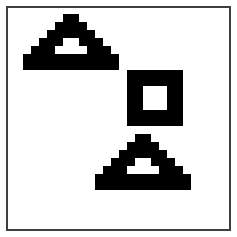

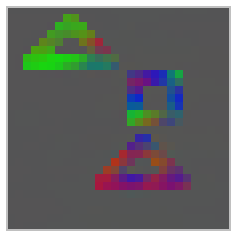

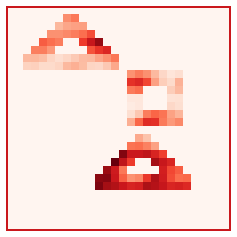

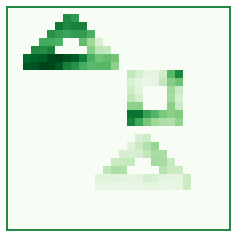

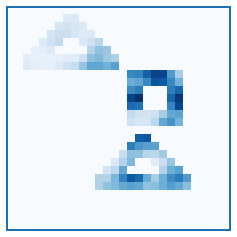

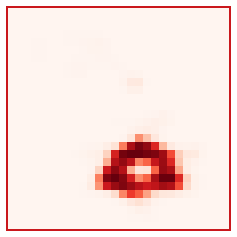

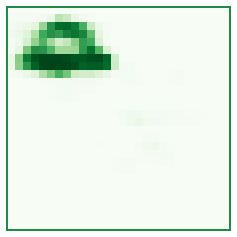

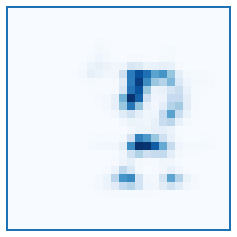

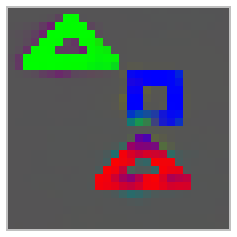

In [198]:
fig = plot_img(dat, 'figures/alg/01.png', 'gray_r')
fig = plot_img(init_grp, 'figures/alg/11.png')
for k in range(init_grp.shape[-1]):
    fig = plot_img(init_grp[:, :, k]*dat, 'figures/alg/2{}.png'.format(k), cmap=['Reds','Greens','Blues'][k])
for k in range(init_grp.shape[-1]):
    fig = plot_img(out[:, :, k], 'figures/alg/3{}.png'.format(k), cmap=['Reds','Greens','Blues'][k])
fig = plot_img(final_grp, 'figures/alg/41.png')